# Self-Organizing Maps (SOM)


## Intro
A self organising map or herafter SOM is a unsupervised Machine Learnng algorithm used for clustering and reducing dimensionality of large datasets. Information about SOM and the algorithm can be found in this video: https://www.youtube.com/watch?v=g8O6e9C_CfY. We are using Scikit learns SOM algorithm: https://pypi.org/project/sklearn-som/. 

First part of this notebook is to use SOM analysis on the FWI 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import pandas as pd
import cartopy.crs as ccrs
import salem
from tqdm import tqdm
from sklearn import preprocessing
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib
import glob

In [2]:
#FWI_files=sorted(glob.glob('/mnt/data/FWI_WRF/*', recursive=True)) 
FWI_files=sorted(glob.glob('/mnt/data/FWI_WRF/*', recursive=True)) 

In [3]:
FWI_files

['/mnt/data/FWI_WRF/FWI_2000.nc',
 '/mnt/data/FWI_WRF/FWI_2001.nc',
 '/mnt/data/FWI_WRF/FWI_2002.nc',
 '/mnt/data/FWI_WRF/FWI_2003.nc',
 '/mnt/data/FWI_WRF/FWI_2004.nc',
 '/mnt/data/FWI_WRF/FWI_2005.nc',
 '/mnt/data/FWI_WRF/FWI_2006.nc',
 '/mnt/data/FWI_WRF/FWI_2007.nc',
 '/mnt/data/FWI_WRF/FWI_2008.nc',
 '/mnt/data/FWI_WRF/FWI_2009.nc',
 '/mnt/data/FWI_WRF/FWI_2010.nc',
 '/mnt/data/FWI_WRF/FWI_2011.nc',
 '/mnt/data/FWI_WRF/FWI_2012.nc',
 '/mnt/data/FWI_WRF/FWI_2013.nc',
 '/mnt/data/FWI_WRF/FWI_2014.nc',
 '/mnt/data/FWI_WRF/FWI_2015.nc',
 '/mnt/data/FWI_WRF/FWI_2016.nc',
 '/mnt/data/FWI_WRF/FWI_2017.nc',
 '/mnt/data/FWI_WRF/FWI_2018.nc',
 '/mnt/data/FWI_WRF/FWI_2019.nc',
 '/mnt/data/FWI_WRF/FWI_2020.nc']

In [5]:
ds = xr.open_dataset("/mnt/data/FWI_WRF/FWI_2020.nc")

(array([1.28675e+07, 6.59836e+05, 8.63470e+04, 1.58790e+04, 4.45600e+03,
        1.76100e+03, 7.84000e+02, 2.73000e+02, 1.11000e+02, 5.20000e+01]),
 array([3.99439019e-10, 1.74981599e+01, 3.49963197e+01, 5.24944796e+01,
        6.99926394e+01, 8.74907993e+01, 1.04988959e+02, 1.22487119e+02,
        1.39985279e+02, 1.57483439e+02, 1.74981599e+02]),
 <BarContainer object of 10 artists>)

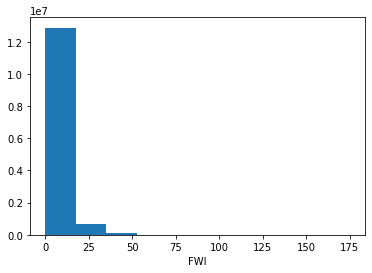

In [6]:
ds.FWI.plot()

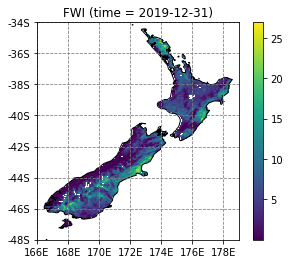

In [7]:
ds.FWI[0,:,:].salem.quick_map()

For the SOM documantiation go to: https://sklearn-som.readthedocs.io/en/latest/. The function below calculates a SOM in m x n dimensions. The shape of the training data must be 2D hence, (time, lat * lon). The input must be a numpy array and can not contain any NA values. 

In [8]:
FWI = ds.FWI
time = ds.time
ds_np=xr.DataArray.to_numpy(FWI.load())
ds_np_nonan = np.nan_to_num(ds_np, nan = -9999) # water is all set to this to seperate it

In [20]:
ds_np.shape  # needs to be 2d vector not 3d for som, func below reduces to 2d
# time, lat, lon

(367, 508, 472)

In [21]:
def calc_som(m,n, data):
    lat_dim = data.shape[1]
    lon_dim = data.shape[2]
    # Build a m x n SOM 
    som = SOM(m=m, n=n, dim=lat_dim*lon_dim, lr=0.5)

    # Fit it to the data
    som.fit(data.reshape((data.shape[0],lat_dim*lon_dim)), epochs =10)

    # Assign each datapoint to its predicted cluster
    predictions = som.predict(data.reshape((data.shape[0],lat_dim*lon_dim)))
    return som, predictions

In [22]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan)

CPU times: user 8min 10s, sys: 52.4 s, total: 9min 3s
Wall time: 9min 3s


In [28]:
def calc_som(m,n, data):
    lat_dim = data.shape[1]
    lon_dim = data.shape[2]
    # Build a m x n SOM 
    som = SOM(m=m, n=n, dim=lat_dim*lon_dim, lr=1)

    # Fit it to the data
    som.fit(data.reshape((data.shape[0],lat_dim*lon_dim)), epochs =20)

    # Assign each datapoint to its predicted cluster
    predictions = som.predict(data.reshape((data.shape[0],lat_dim*lon_dim)))
    return som, predictions

In [29]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan)

CPU times: user 8min 9s, sys: 50.3 s, total: 8min 59s
Wall time: 9min


(array([  4.,   6.,   6.,  59.,   0.,  93., 178.,   5.,   8.,   8.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

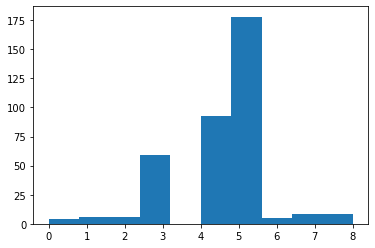

In [23]:
plt.hist(predict_som)

For each SOM node a mean of the FWI is calculated

In [12]:
som_dict = {}
for i in range(0,9):
    mask = predict_som == i
    som_FWI = FWI[mask]
    mean_FWI = som_FWI.mean(dim="time")
    som_dict[str(i)]=mean_FWI.load()

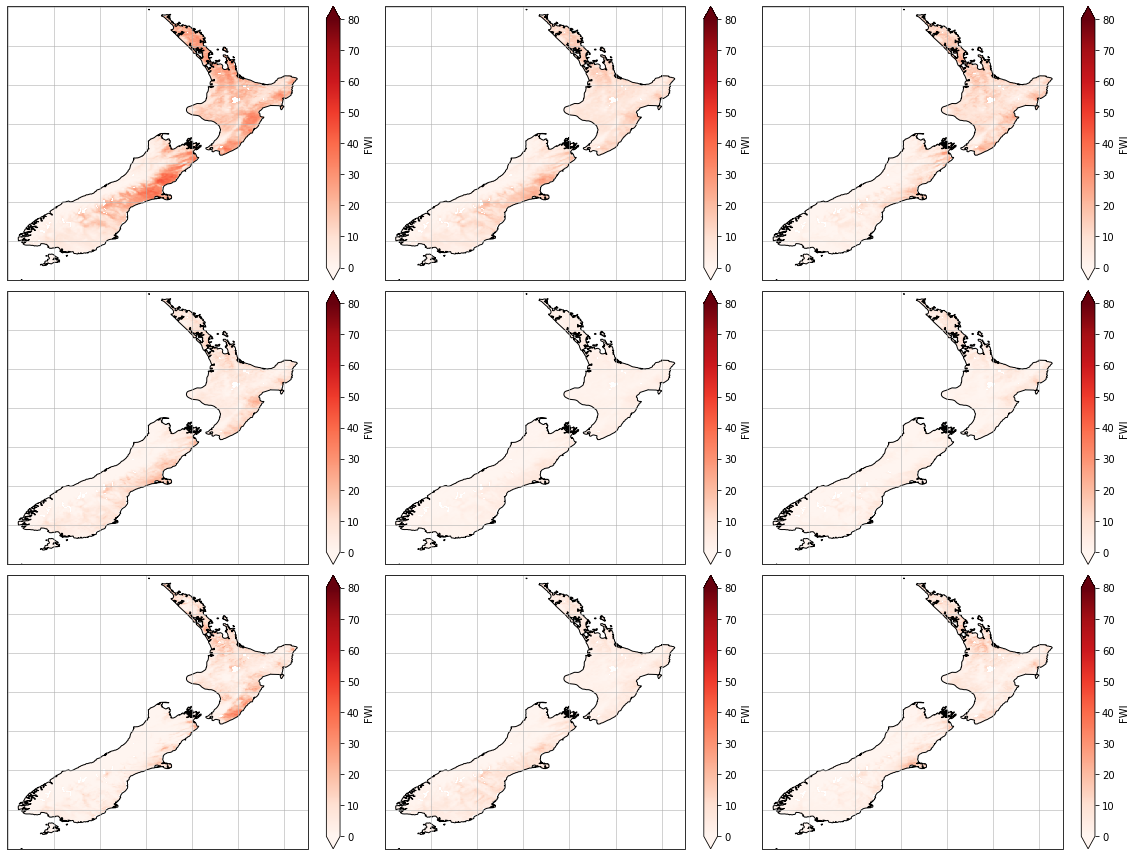

In [13]:
proj = FWI.salem.cartopy()
color_map ="Reds"
fig = plt.figure(figsize=[16,12])
for i in range(0,9):
    ax = plt.subplot(3,3,i+1,projection=proj)
    som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=0, vmax=80, extend="both")

    ax.coastlines('10m', linewidth=1)
    ax.set_aspect('auto')
    ax.set_extent(FWI.salem.grid.extent, crs=proj)
    ax.gridlines(alpha=0.7)
    plt.tight_layout()
#plt.savefig("som_4by4.pdf", dpi=60) 

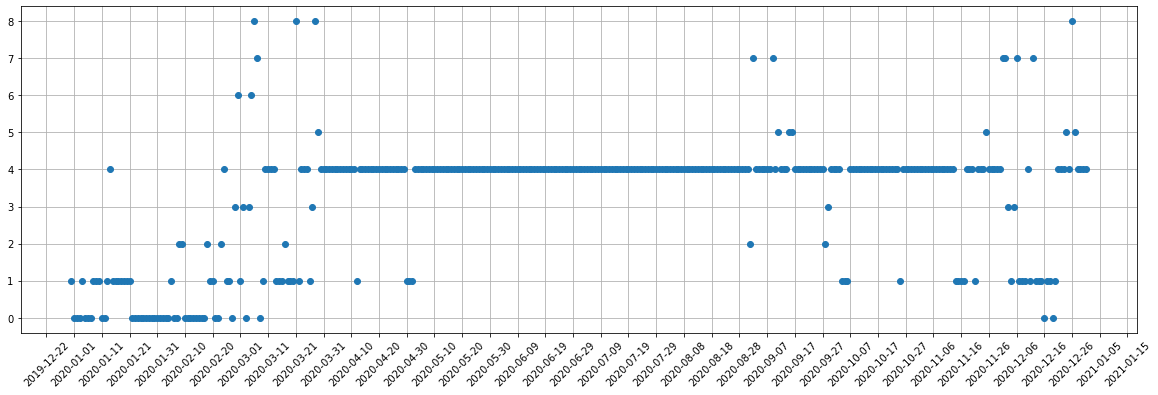

In [14]:
plt.figure(figsize=(20, 6))
plt.plot(time,predict_som, "o")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xticks(rotation=45);

In [30]:
def calc_som(m,n, data):
    lat_dim = data.shape[1]
    lon_dim = data.shape[2]
    # Build a m x n SOM 
    som = SOM(m=m, n=n, dim=lat_dim*lon_dim, lr=0.5)

    # Fit it to the data
    som.fit(data.reshape((data.shape[0],lat_dim*lon_dim)), epochs=10)

    # Assign each datapoint to its predicted cluster
    predictions = som.predict(data.reshape((data.shape[0],lat_dim*lon_dim)))
    return som, predictions

In [31]:
%%time
som, predict_som = calc_som(2,2, ds_np_nonan)

CPU times: user 7min 52s, sys: 37.8 s, total: 8min 30s
Wall time: 8min 30s


(array([ 70.,   0.,   0.,  11.,   0.,   0., 280.,   0.,   0.,   6.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

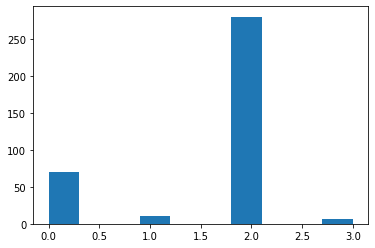

In [32]:
plt.hist(predict_som)

In [33]:
som_dict = {}
for i in range(0,4):
    mask = predict_som == i
    som_FWI = FWI[mask]
    mean_FWI = som_FWI.mean(dim="time")
    som_dict[str(i)]=mean_FWI.load()

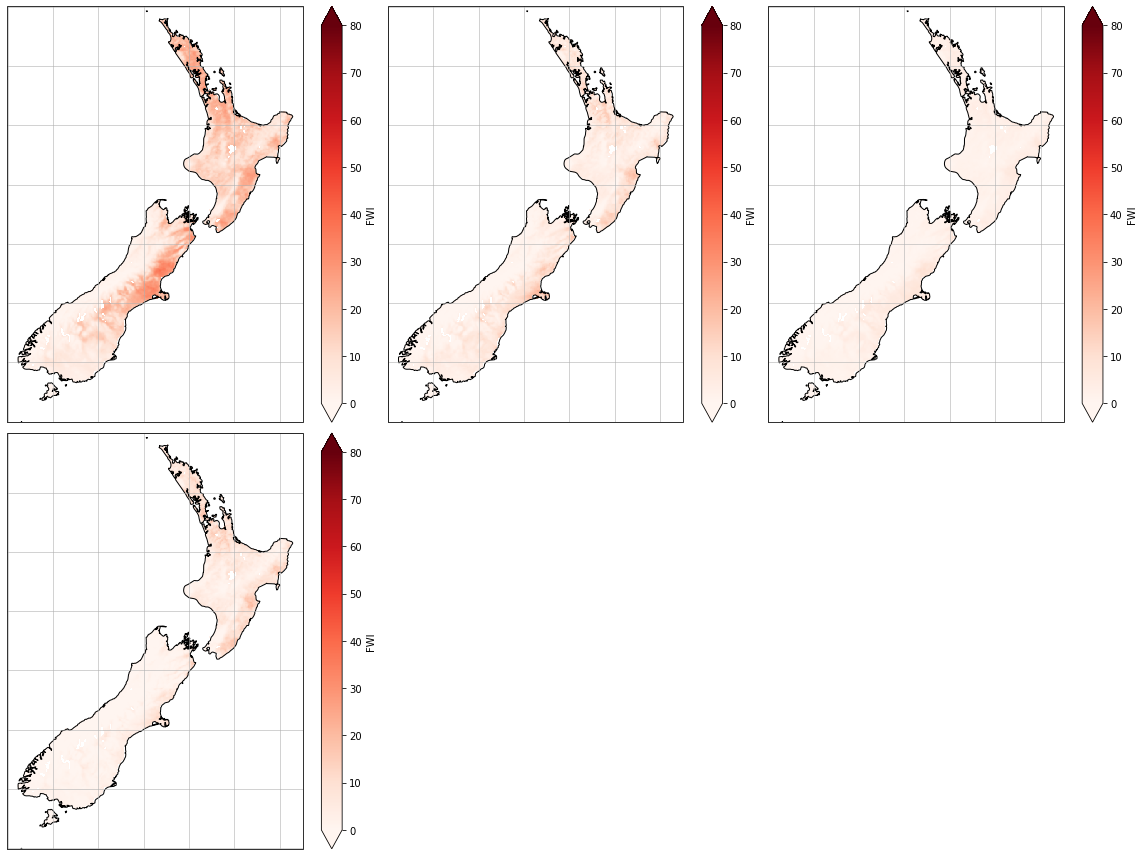

In [34]:
proj = FWI.salem.cartopy()
color_map ="Reds"
fig = plt.figure(figsize=[16,12])
for i in range(0,4):
    ax = plt.subplot(2,3,i+1,projection=proj)
    som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=0, vmax=80, extend="both")

    ax.coastlines('10m', linewidth=1)
    ax.set_aspect('auto')
    ax.set_extent(FWI.salem.grid.extent, crs=proj)
    ax.gridlines(alpha=0.7)
    plt.tight_layout()
#plt.savefig("som_4by4.pdf", dpi=60) 

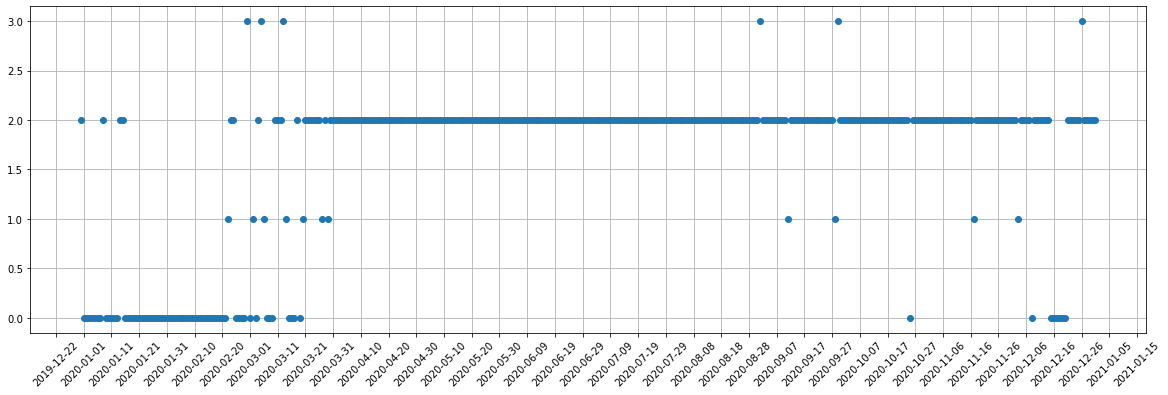

In [35]:
plt.figure(figsize=(20, 6))
plt.plot(time,predict_som, "o")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xticks(rotation=45);

### Assignment 
a) Try to change number of nodes. e.g 4x4 or 2x2. 
What number of nodes works the best? 

b) Play with the learning rate and epoch numbers.

### Assignment 
a) With the prefered settings from above, try to create a SOM for one of the other data variables in the FWI-fil. e.g. ISI

In [36]:
ISI = ds.ISI

In [37]:
ISI_np=xr.DataArray.to_numpy(ds.ISI.load())
ISI_np_nonan = np.nan_to_num(ISI_np, nan = -9999)

## Assignment

a) Use the indexing from the SOM to calculate the mean of the ISI for each node

In [ ]:
## see around 2:24 in lecture 10ish

In [38]:
som_ISI_dict = {}
for i in range(0,4):
    mask = predict_som_4 == i
    som_ISI = ISI[mask]
    mean_ISI = som_ISI.mean(dim="time")
    som_ISI_dict[str(i)]=mean_ISI.load()

NameError: name 'predict_som_4' is not defined